In [1]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
from dataAnalyzer import *
from private_tool import *
from dataHandler import *
from numpy import array
import pandas as pd


In [2]:
experimentNum = 9
experimentIdx = 4
Experiments = [MotorImageryDataset(parentDirectory(dir=currDir, separator="\\", n=1)+'/bcicompetitionIV2a/A0'+str(i+1)+'T.npz') for i in range(experimentNum)]

In [3]:
# [7, 9, 10, 11]
channels = [i for i in range(1, 23)]

samplingRate = 250 #Hz
trialsByClasses = array([i.get_trials_by_classes(channels=channels) for i in Experiments])

In [4]:
len(trialsByClasses[0]["left"][0])

69

In [5]:
channelNum = len(channels)
m = len(trialsByClasses[0]["left"])
channelNum, m

(22, 22)

In [6]:
bandpassedTrialsByClasses = [{i:[[] for _ in range(channelNum)] for i in j.mi_types.values()} for j in Experiments]
for k in range(experimentNum):
    for key in trialsByClasses[k].keys():
        for i in range(channelNum):
            bandpassedTrialsByClasses[k][key][i] = np.array([bandpass_filter(data=trialsByClasses[k][key][i][j], 
                                                                sample_rate=samplingRate, 
                                                                cutoff_low=5, 
                                                                cutoff_high=50)\
                                                for j in range(len(trialsByClasses[k][key][i]))])

In [7]:
# bandpassedTrialsByClasses[2]["left"][2].shape

In [8]:
# 현재 상태는 experiment - class - channel - trial - signal
# class - experiment - trial - channel - signal로 수정하자
bandpassedTrialsByClasses = {key:array([[bandpassedTrialsByClasses[i][key][j] for j in range(channelNum)] for i in range(experimentNum)]) for key in Experiments[0].mi_types.values()}
# bandpassedTrialsByClasses["left"][8][0].shape
# i: experiment
# j: trial

C:\Users\jihun\AppData\Local\Temp\ipykernel_7580\3323506164.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bandpassedTrialsByClasses = {key:array([[bandpassedTrialsByClasses[i][key][j] for j in range(channelNum)] for i in range(experimentNum)]) for key in Experiments[0].mi_types.values()}


In [9]:
minTrialsNum = sorted([len(bandpassedTrialsByClasses["left"][i][0]) for i in range(experimentNum)])[0]
bandpassedTrialsByClasses = {i:[bandpassedTrialsByClasses[i][j] for j in range(experimentNum)] for i in Experiments[0].mi_types.values()}

In [10]:
left_csp_filter = CSP_filter(len(bandpassedTrialsByClasses["left"][experimentIdx]), bandpassedTrialsByClasses["left"][experimentIdx])
right_csp_filter = CSP_filter(len(bandpassedTrialsByClasses["right"][experimentIdx]), bandpassedTrialsByClasses["right"][experimentIdx])
tongue_csp_filter = CSP_filter(len(bandpassedTrialsByClasses["tongue"][experimentIdx]), bandpassedTrialsByClasses["tongue"][experimentIdx])
foot_csp_filter = CSP_filter(len(bandpassedTrialsByClasses["foot"][experimentIdx]), bandpassedTrialsByClasses["foot"][experimentIdx])

In [11]:
bandpassedTrials = {i:[] for i in Experiments[0].mi_types.values()}
for i in Experiments[0].mi_types.values():
    for j in range(len(bandpassedTrialsByClasses)):
        bandpassedTrials[i]

In [12]:
# CSP_passed_left_data = np.array([[bandpassedTrialsByClasses[i][j].T@left_csp_filter for j in range(minTrialsNum)] for i in range(experimentNum)])
CSP_passed_left_data = [j.T@left_csp_filter for j in bandpassedTrialsByClasses["left"][experimentIdx]]
CSP_passed_right_data = [j.T@right_csp_filter for j in bandpassedTrialsByClasses["right"][experimentIdx]]
CSP_passed_tongue_data = [j.T@tongue_csp_filter for j in bandpassedTrialsByClasses["tongue"][experimentIdx]]
CSP_passed_foot_data = [j.T@foot_csp_filter for j in bandpassedTrialsByClasses["foot"][experimentIdx]]

In [13]:
len(CSP_passed_left_data)

22

In [14]:
# bandpassedTrialsByClasses["right"][0]["right"][0]

In [15]:
print(array(CSP_passed_left_data).shape)
CSP_passed_left_data = [np.array([j.T for j in i]).T for i in CSP_passed_left_data]
CSP_passed_right_data = [np.array([j.T for j in i]).T for i in CSP_passed_right_data]
CSP_passed_tongue_data = [np.array([j.T for j in i]).T for i in CSP_passed_tongue_data]
CSP_passed_foot_data = [np.array([j.T for j in i]).T for i in CSP_passed_foot_data]

(22, 1875, 63)


In [16]:
array(CSP_passed_left_data).shape

(22, 63, 1875)

In [17]:
CSP_passed_left_data = array([i.T for i in array(CSP_passed_left_data).T]).T
CSP_passed_right_data = array([i.T for i in array(CSP_passed_right_data).T]).T
CSP_passed_tongue_data = array([i.T for i in array(CSP_passed_tongue_data).T]).T
CSP_passed_foot_data = array([i.T for i in array(CSP_passed_foot_data).T]).T

In [18]:
from math import log
m = 3

leftVar = np.array([np.array([np.var(CSP_passed_left_data[i][j]) for j in range(channelNum)]) for i in range(minTrialsNum)])
rightVar = np.array([np.array([np.var(CSP_passed_right_data[i][j]) for j in range(channelNum)]) for i in range(minTrialsNum)])
tongueVar = np.array([np.array([np.var(CSP_passed_tongue_data[i][j]) for j in range(channelNum)]) for i in range(minTrialsNum)])
footVar = np.array([np.array([np.var(CSP_passed_foot_data[i][j]) for j in range(channelNum)]) for i in range(minTrialsNum)])


leftVarRatio = np.array([np.array([log(leftVar[i][j-m]/sum(leftVar[i])) for j in range(m*2)]) for i in range(minTrialsNum)])
rightVarRatio = np.array([np.array([log(rightVar[i][j-m]/sum(rightVar[i])) for j in range(m*2)]) for i in range(minTrialsNum)])
tongueVarRatio = np.array([np.array([log(tongueVar[i][j-m]/sum(tongueVar[i])) for j in range(m*2)]) for i in range(minTrialsNum)])
footVarRatio = np.array([np.array([log(footVar[i][j-m]/sum(footVar[i])) for j in range(m*2)]) for i in range(minTrialsNum)])

In [19]:
leftVarRatioDF = pd.DataFrame(leftVarRatio)
rightVarRatioDF = pd.DataFrame(rightVarRatio)
tongueVarRatioDF = pd.DataFrame(tongueVarRatio)
footVarRatioDF = pd.DataFrame(footVarRatio)

labelDF = pd.DataFrame([0]*minTrialsNum + [1]*minTrialsNum + [2]*minTrialsNum + [3]*minTrialsNum)

In [20]:
VarRatioDF = pd.concat([leftVarRatioDF, rightVarRatioDF, tongueVarRatioDF, footVarRatioDF], axis=0)
VarRatioDF = VarRatioDF.reset_index()
VarRatioDF = pd.concat([VarRatioDF, labelDF], axis=1).iloc[:,1:]
VarRatioDF.columns = [f"{n}" for n in range(m*2)] + ["target"]
VarRatioDF

,0,1,2,3,4,5,target
0,-3.204462,-3.278096,-3.546410,-2.934509,-2.889075,-2.795803,0
1,-3.102497,-3.058768,-3.523554,-3.077271,-2.976087,-2.847130,0
2,-3.055502,-3.055088,-3.666315,-3.131898,-3.052173,-2.931650,0
3,-3.048343,-3.115265,-3.437050,-3.108878,-3.065573,-2.993128,0
4,-3.160291,-3.115734,-3.255756,-3.030997,-2.960478,-2.933203,0
...,...,...,...,...,...,...,...
207,-3.197580,-3.225693,-3.566081,-3.005665,-2.928129,-2.832527,3
208,-3.070706,-3.111524,-3.493111,-3.046889,-2.974649,-2.904300,3
209,-3.199614,-3.208341,-3.510539,-2.999750,-2.890645,-2.777343,3
210,-3.160221,-3.215271,-3.553770,-2.902825,-2.850609,-2.797292,3


In [21]:

x = VarRatioDF.drop(['target'], axis=1).values 
y = VarRatioDF['target'].values # 종속변인 추출
x = StandardScaler().fit_transform(x)
pd.DataFrame(x)

,0,1,2,3,4,5
0,-1.585506,-1.520058,0.207519,1.450585,1.140547,1.464010
1,0.428679,1.487403,0.375116,-0.989192,-0.602234,0.421684
2,1.357022,1.537862,-0.671726,-1.922760,-2.126194,-1.294702
3,1.498442,0.712713,1.009441,-1.529349,-2.394580,-2.543164
4,-0.712958,0.706280,2.338838,-0.198383,-0.289597,-1.326235
...,...,...,...,...,...,...
207,-1.449569,-0.801507,0.063278,0.234543,0.358323,0.718236
208,1.056688,0.763999,0.598351,-0.469965,-0.573440,-0.739289
209,-1.489748,-0.563567,0.470552,0.335624,1.109096,1.838896
210,-0.711573,-0.658600,0.153552,1.992056,1.910995,1.433780


In [22]:
n_componunts = 3

PCA = PrincipalComponuntAnalysis(n_componunts=n_componunts, data=x)
principalDf = PCA.principalDf

In [23]:
sum(PCA.explained_variance_ratio_())

0.8933650494235956

In [24]:
pd.concat([principalDf, labelDF], axis=1)

,principal component1,principal component2,principal component3,0
0,-3.186482,0.244376,-0.274475,0
1,1.372759,0.253375,0.371337,0
2,3.694996,-0.687409,-0.378734,0
3,3.916888,1.094111,-0.880589,0
4,0.793562,2.609001,-0.090634,0
...,...,...,...,...
207,-1.586662,0.141877,-0.716039,3
208,1.612707,0.543814,0.331543,3
209,-2.391187,0.371147,-0.226398,3
210,-3.017787,0.143676,1.162434,3


In [25]:
# import matplotlib.pyplot as plt

# fig = plt.figure(figsize = (8, 8))
# ax = fig.add_subplot(1, 1, 1)
# ax.set_xlabel('Principal componunt 1', fontsize = 15)
# ax.set_ylabel('Principal componunt 2', fontsize = 15)
# ax.set_title('1 componunt PCA', fontsize=20)

# targets = [0, 1, 2, 3]
# colors = ['r', 'g', 'b', 'purple']
# for target, color in zip(targets,colors):
#     indicesToKeep = VarRatioDF['target'] == target
#     ax.scatter(principalDf.loc[indicesToKeep, 'principal componunt1']
#                , principalDf.loc[indicesToKeep, 'principal componunt3']
#                , c = color
#                , s = 50, alpha=0.5)
# ax.legend(targets)
# ax.grid()

In [26]:
# last_data = pd.concat([principalDf.loc[:, 'principal componunt1'], 
#     principalDf.loc[:, 'principal componunt2'], 
#     labelDF], axis=1)

# last_data.columns = ['principal componunt1', 'principal componunt2', 'label']           

In [27]:
# # 데이터를 DataFrame으로 생성
df = pd.concat([principalDf, labelDF], axis=1)
df.columns = [f"principal componunt{i+1}" for i in range(n_componunts)]+["label"]
print(df.columns)

# # 3D scatter plot 그리기
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # 클래스별로 색상을 다르게 설정
# colors = ['r', 'g', 'b', 'c']
# for i in range(4):  # 클래스 개수에 맞게 범위 설정
#     subset = df[df['label'] == i]
#     ax.scatter(subset['principal componunt1'], subset['principal componunt2'], subset['principal componunt3'], c=colors[i], label=f'Class {i}')

# ax.set_xlabel('Principal componunt 1')
# ax.set_ylabel('Principal componunt 2')
# ax.set_zlabel('Principal componunt 3')
# ax.set_title('3D Scatter Plot of Principal componunts')
# ax.legend()
# plt.show()

Index(['principal componunt1', 'principal componunt2', 'principal componunt3',
       'label'],
      dtype='object')


In [28]:
import numpy as np
np.save("./dataframe", df)

In [29]:
from dataAnalyzer import *
LDA_DF = pd.DataFrame(lda(principalDf, labelDF, 3))

c:\Users\jihun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


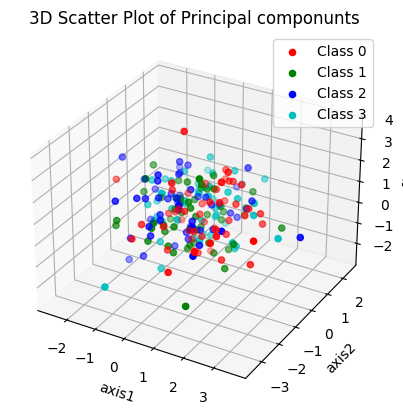

In [30]:
LDA_DF = pd.concat([LDA_DF, labelDF], axis=1)
LDA_DF.columns = [f"axis{i+1}" for i in range(n_componunts)]+["label"]

# 3D scatter plot 그리기
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 클래스별로 색상을 다르게 설정
colors = ['r', 'g', 'b', 'c']
for i in range(4):  # 클래스 개수에 맞게 범위 설정
    subset = LDA_DF[LDA_DF['label'] == i]
    ax.scatter(subset['axis1'], subset['axis2'], subset['axis3'], c=colors[i], label=f'Class {i}')

ax.set_xlabel('axis1')
ax.set_ylabel('axis2')
ax.set_zlabel('axis3')
ax.set_title('3D Scatter Plot of Principal componunts')
ax.legend()
plt.show()